In [5]:
MAX_SUB = 1 
MAX_SES = 1

In [4]:
import matplotlib.pyplot as plt
import logging
import mne
from mne.time_frequency import psd_array_welch
import neurokit2 as nk
import eeglib
import numpy as nd
import pandas as pd
from functools import reduce
import sys
import scipy
import matplotlib
import sklearn

from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


def psd_extraction(l_freq, h_freq):
    global spectrum
    psds, freqs = spectrum.get_data(return_freqs=True)
    freq_band_index = []
    for x in freqs:
        if l_freq < x < h_freq:
            freq_index = list(freqs).index(x)
            freq_band_index.append(freq_index)

    power_band = []
    power_band_sum = []

    for x in range(len(psds)):
        count = 0
        ch_list = []
        for y in psds[x]:
            if count == len(freq_band_index):
                power_band.append(ch_list)
                power_band_sum.append(sum(ch_list))
                break
            if list(psds[x]).index(y) == freq_band_index[count]:
                psd_index = list(psds[x]).index(y)
                ch_list.append(y)
                count+=1
    
    return power_band_sum



In [7]:
def specPerPatient(init_extension):
    global spectrum
    logging.basicConfig(level='INFO', format='%(asctime)s %(levelname)s [%(module)s:%(lineno)d] %(message)s')
    logging.getLogger('mne').setLevel('ERROR')

    sub_count = MAX_SUB
    ses_count = MAX_SES

    extension = init_extension

    sub_list = []
    for sub in range(1, sub_count + 1):
        logging.info('Loading subject %03d' % sub)
        ses_list = []

        for ses in range(1, ses_count + 1):
            data_path = "/Users/nivinattudurai/Downloads/dataverse_files/" + extension
            data = mne.io.read_raw_edf(data_path, preload=True)
            data.drop_channels(['T4', 'T6', 'O2', 'T3', 'T5', 'O1', 'C3', 'C4', 'P3', 'P4', 'Cz', 'Fz', 'Pz'])
            ses_list.append(data)
        
        sub_list.append(ses_list)

    raw:mne.io.Raw = sub_list[0][0]


    raw = raw.filter(l_freq=0.03, h_freq=25.0)

    spectrum = raw.compute_psd(method="welch")

    band_sums = []
    band_sums.append(psd_extraction(1, 3))
    band_sums.append(psd_extraction(4, 7))
    band_sums.append(psd_extraction(8, 12))
    band_sums.append(psd_extraction(13, 30))
    band_sums.append(psd_extraction(30, 100))
    
    #channels = ['Fp2', 'F8', 'Fp1', 'F7', 'F4', 'F3']
    #bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']

    #df = pd.DataFrame(band_sums, bands, channels) 

    #print(df)
    #print('------------------')

    flatten_list = reduce(lambda z, y :z + y, band_sums)

    return flatten_list    



In [8]:
#patients = ['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 
#            'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10']
#bands = ['Fp2: delta', 'F8: delta', 'Fp1: delta', 'F7: delta', 'F4: delta', 'F3: delta', 
#            'Fp2: theta', 'F8: theta', 'Fp1: theta', 'F7: theta', 'F4: theta', 'F3: theta', 
#            'Fp2: alpha', 'F8: alpha', 'Fp1: alpha', 'F7: alpha', 'F4: alpha', 'F3: alpha', 
#            'Fp2: beta', 'F8: beta', 'Fp1: beta', 'F7: beta', 'F4: beta', 'F3: beta', 
#            'Fp2: gamma', 'F8: gamma', 'Fp1: gamma', 'F7: gamma', 'F4: gamma', 'F3: gamma']   


all_band_sums = []

for x in range(10):
    if (x+1 != 10):
        all_band_sums.append(specPerPatient("h0" + str(x+1) +".edf"))
    else:
        all_band_sums.append(specPerPatient("h10" +".edf"))

for x in range(10):
    if (x+1 != 10):
        all_band_sums.append(specPerPatient("s0" + str(x+1) +".edf"))
    else:
        all_band_sums.append(specPerPatient("s10" +".edf"))



# all_band_sums.append(specPerPatient("h01.edf"))
# all_band_sums.append(specPerPatient("h02.edf"))
# all_band_sums.append(specPerPatient("h03.edf"))
# all_band_sums.append(specPerPatient("h04.edf"))
# all_band_sums.append(specPerPatient("h05.edf"))

pd.set_option('display.max_colwidth', 40)
pd.set_option('display.max_columns', 0)
pd.set_option('display.expand_frame_repr', True)

labels = ['Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 
'Schizophrenia', 'Schizophrenia', 'Schizophrenia', 'Schizophrenia', 'Schizophrenia', 'Schizophrenia', 'Schizophrenia', 'Schizophrenia', 'Schizophrenia', 'Schizophrenia']

#df = pd.DataFrame(all_band_sums, patients, bands) 
df = pd.DataFrame(all_band_sums) 
df.columns = ['Fp2: delta', 'F8: delta', 'Fp1: delta', 'F7: delta', 'F4: delta', 'F3: delta', 
            'Fp2: theta', 'F8: theta', 'Fp1: theta', 'F7: theta', 'F4: theta', 'F3: theta', 
            'Fp2: alpha', 'F8: alpha', 'Fp1: alpha', 'F7: alpha', 'F4: alpha', 'F3: alpha', 
            'Fp2: beta', 'F8: beta', 'Fp1: beta', 'F7: beta', 'F4: beta', 'F3: beta', 
            'Fp2: gamma', 'F8: gamma', 'Fp1: gamma', 'F7: gamma', 'F4: gamma', 'F3: gamma']
df["Class"] = labels

print(df)



2023-07-14 14:39:23,452 INFO [2492090431:13] Loading subject 001
2023-07-14 14:39:26,129 INFO [2492090431:13] Loading subject 001
2023-07-14 14:39:27,017 INFO [2492090431:13] Loading subject 001
2023-07-14 14:39:27,996 INFO [2492090431:13] Loading subject 001
2023-07-14 14:39:29,265 INFO [2492090431:13] Loading subject 001
2023-07-14 14:39:30,351 INFO [2492090431:13] Loading subject 001
2023-07-14 14:39:31,791 INFO [2492090431:13] Loading subject 001
2023-07-14 14:39:33,030 INFO [2492090431:13] Loading subject 001
2023-07-14 14:39:34,928 INFO [2492090431:13] Loading subject 001
2023-07-14 14:39:36,831 INFO [2492090431:13] Loading subject 001
2023-07-14 14:39:38,607 INFO [2492090431:13] Loading subject 001
2023-07-14 14:39:39,753 INFO [2492090431:13] Loading subject 001
2023-07-14 14:39:41,256 INFO [2492090431:13] Loading subject 001
2023-07-14 14:39:42,805 INFO [2492090431:13] Loading subject 001
2023-07-14 14:39:45,037 INFO [2492090431:13] Loading subject 001
2023-07-14 14:39:46,610 I

      Fp2: delta     F8: delta  ...     F3: gamma          Class
0   3.161738e-11  1.824932e-11  ...  3.235341e-15        Healthy
1   2.522371e-11  1.411712e-11  ...  6.990366e-15        Healthy
2   6.021176e-11  1.719243e-11  ...  3.326985e-15        Healthy
3   7.785501e-11  5.345928e-11  ...  3.403609e-15        Healthy
4   9.597124e-11  2.363183e-11  ...  7.034545e-15        Healthy
5   3.524948e-11  3.053867e-11  ...  1.928418e-14        Healthy
6   1.515405e-10  3.576580e-11  ...  1.847708e-15        Healthy
7   4.336801e-11  1.667097e-11  ...  5.157869e-15        Healthy
8   5.666811e-11  1.818491e-11  ...  4.918794e-15        Healthy
9   2.395157e-11  1.915888e-11  ...  3.763387e-15        Healthy
10  1.653636e-11  9.830893e-12  ...  3.792960e-15  Schizophrenia
11  3.179230e-10  1.064779e-11  ...  2.731556e-15  Schizophrenia
12  1.210164e-11  4.463277e-12  ...  4.312093e-15  Schizophrenia
13  3.028995e-11  6.915625e-12  ...  6.166647e-15  Schizophrenia
14  2.955562e-11  1.80935

In [7]:
print(df.groupby('Class').size())

Class
Healthy          10
Schizophrenia    10
dtype: int64


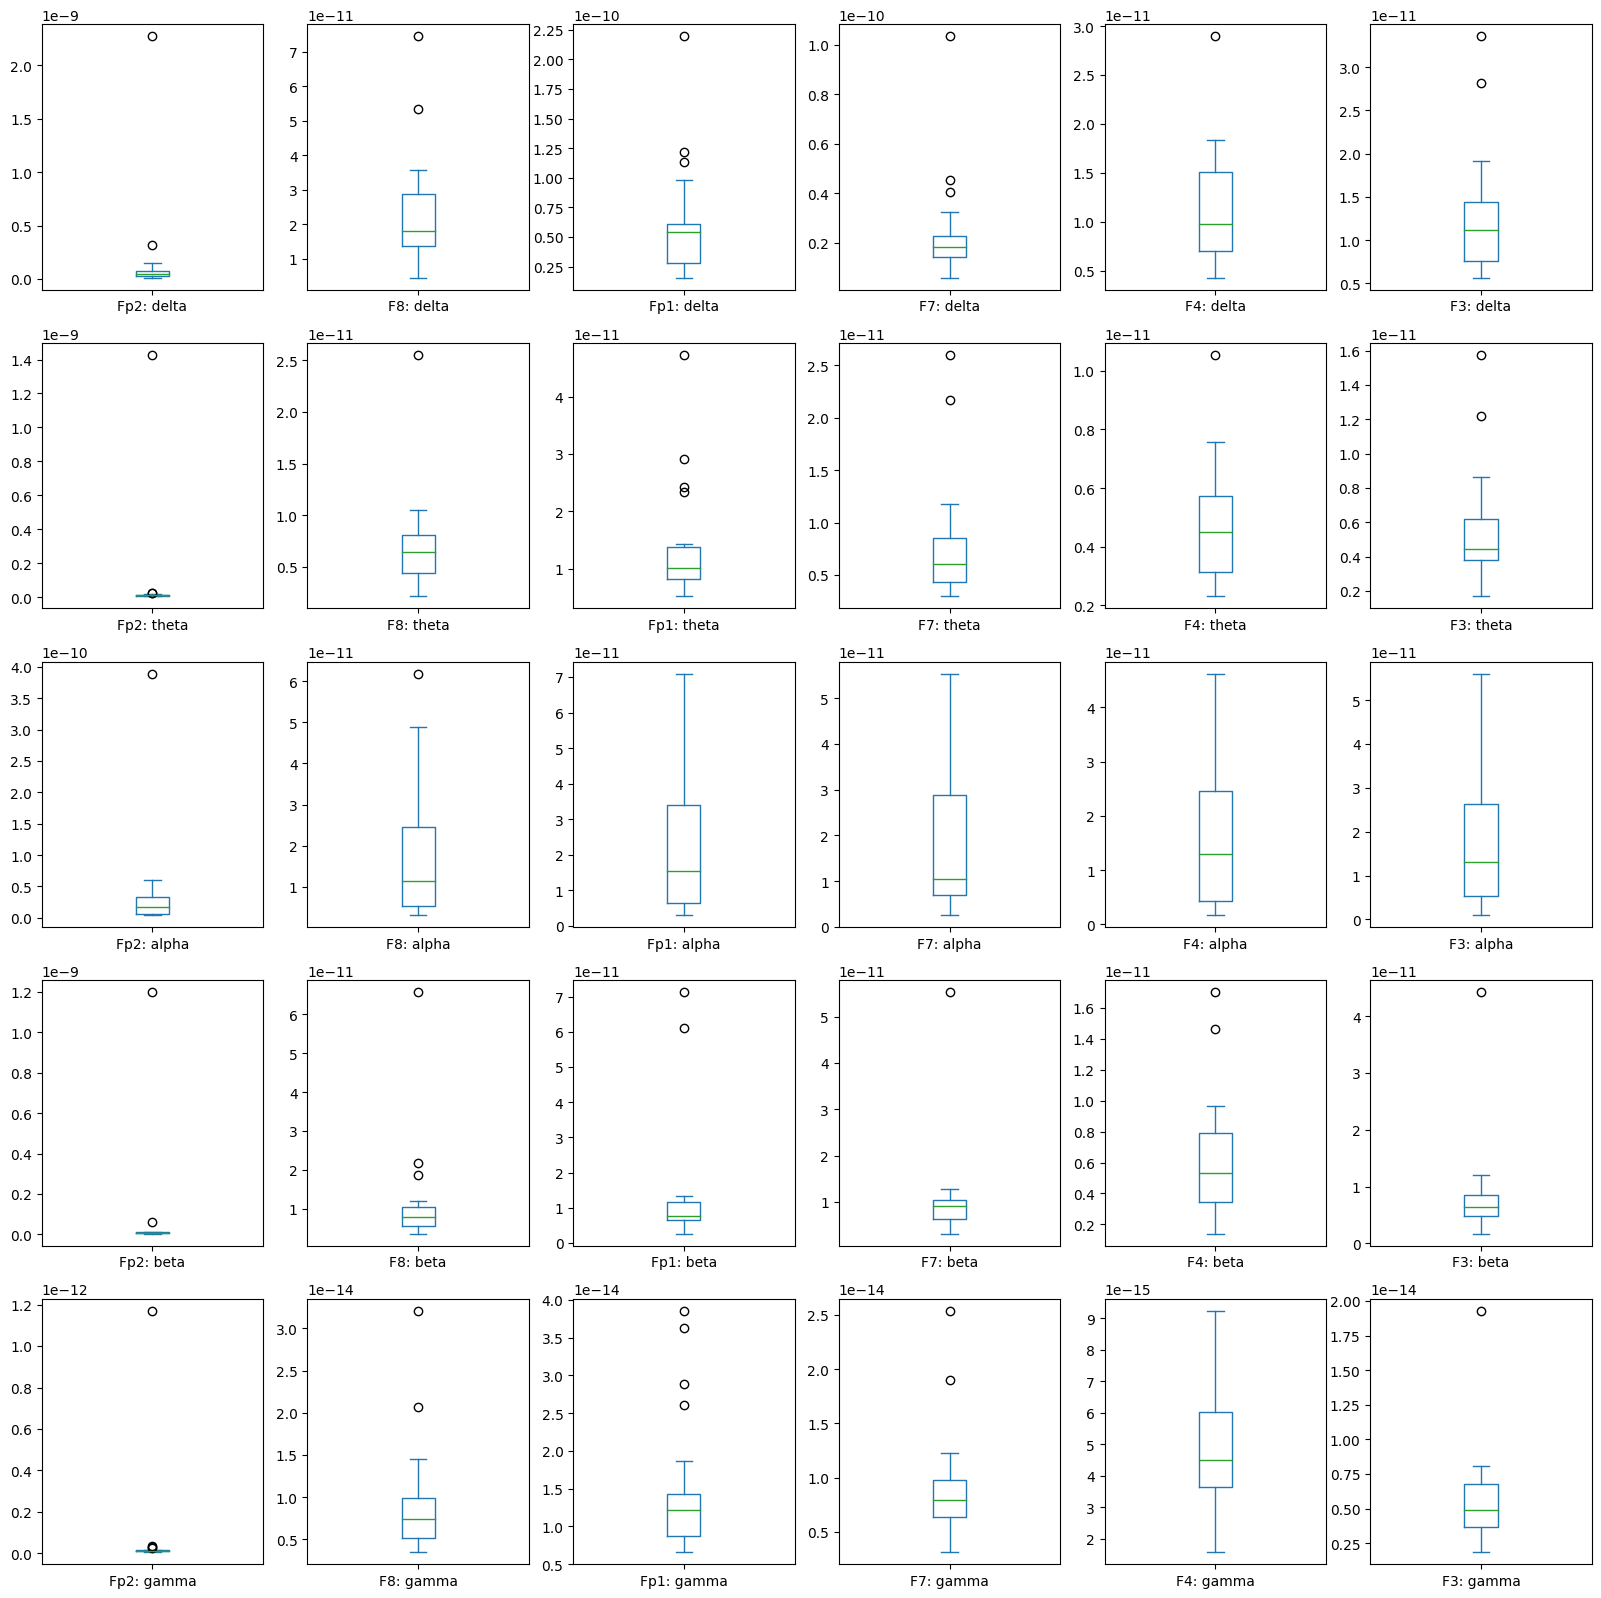

In [ ]:
df.plot(kind='box', subplots=True, layout=(5, 6), figsize=(20, 20), sharex=False, sharey=False)
pyplot.show()

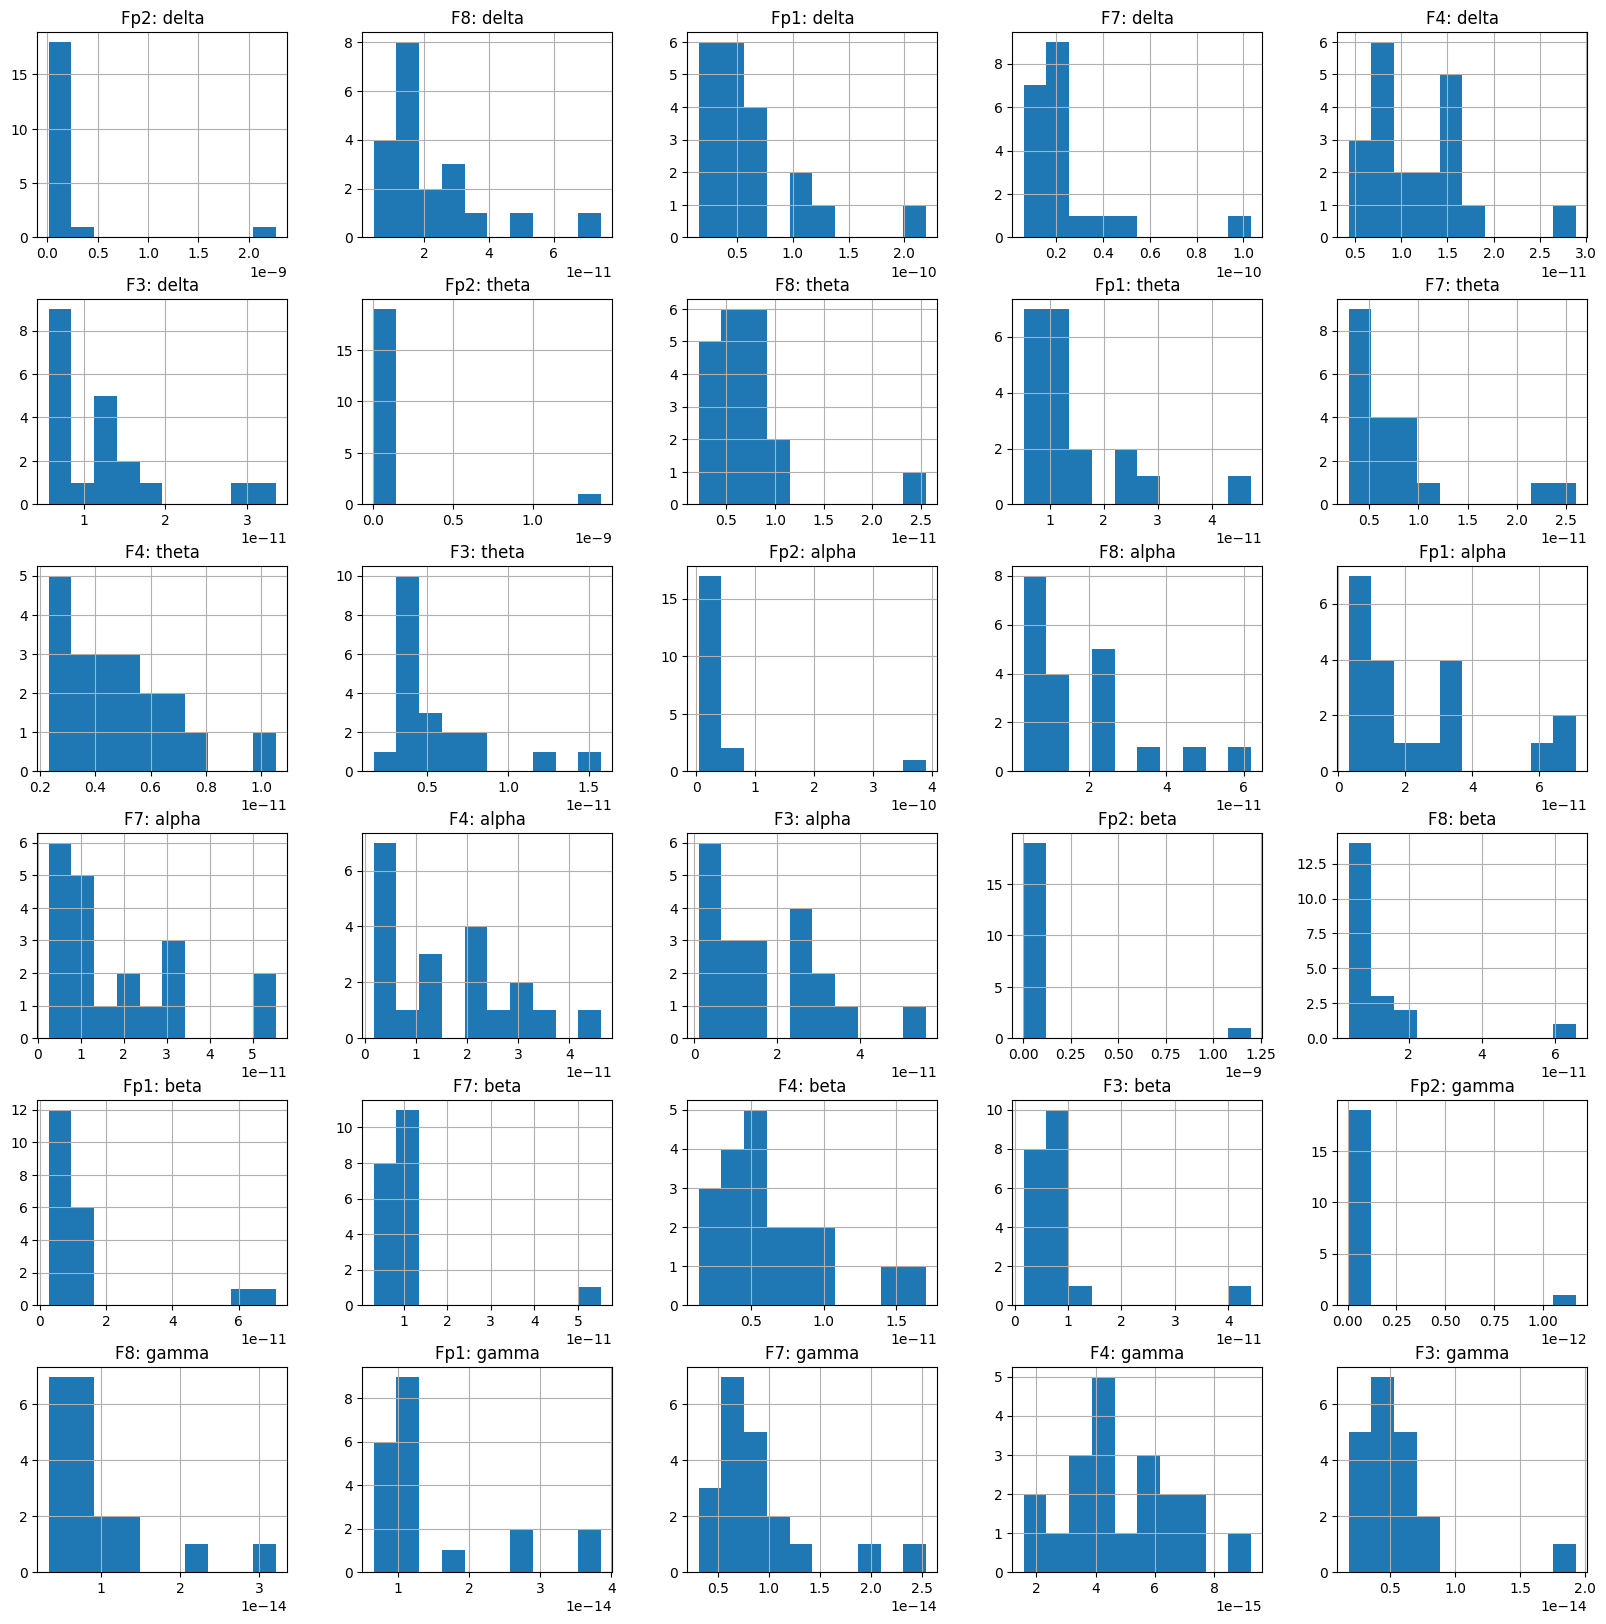

In [ ]:
df.hist(figsize=(20, 20))
pyplot.show()

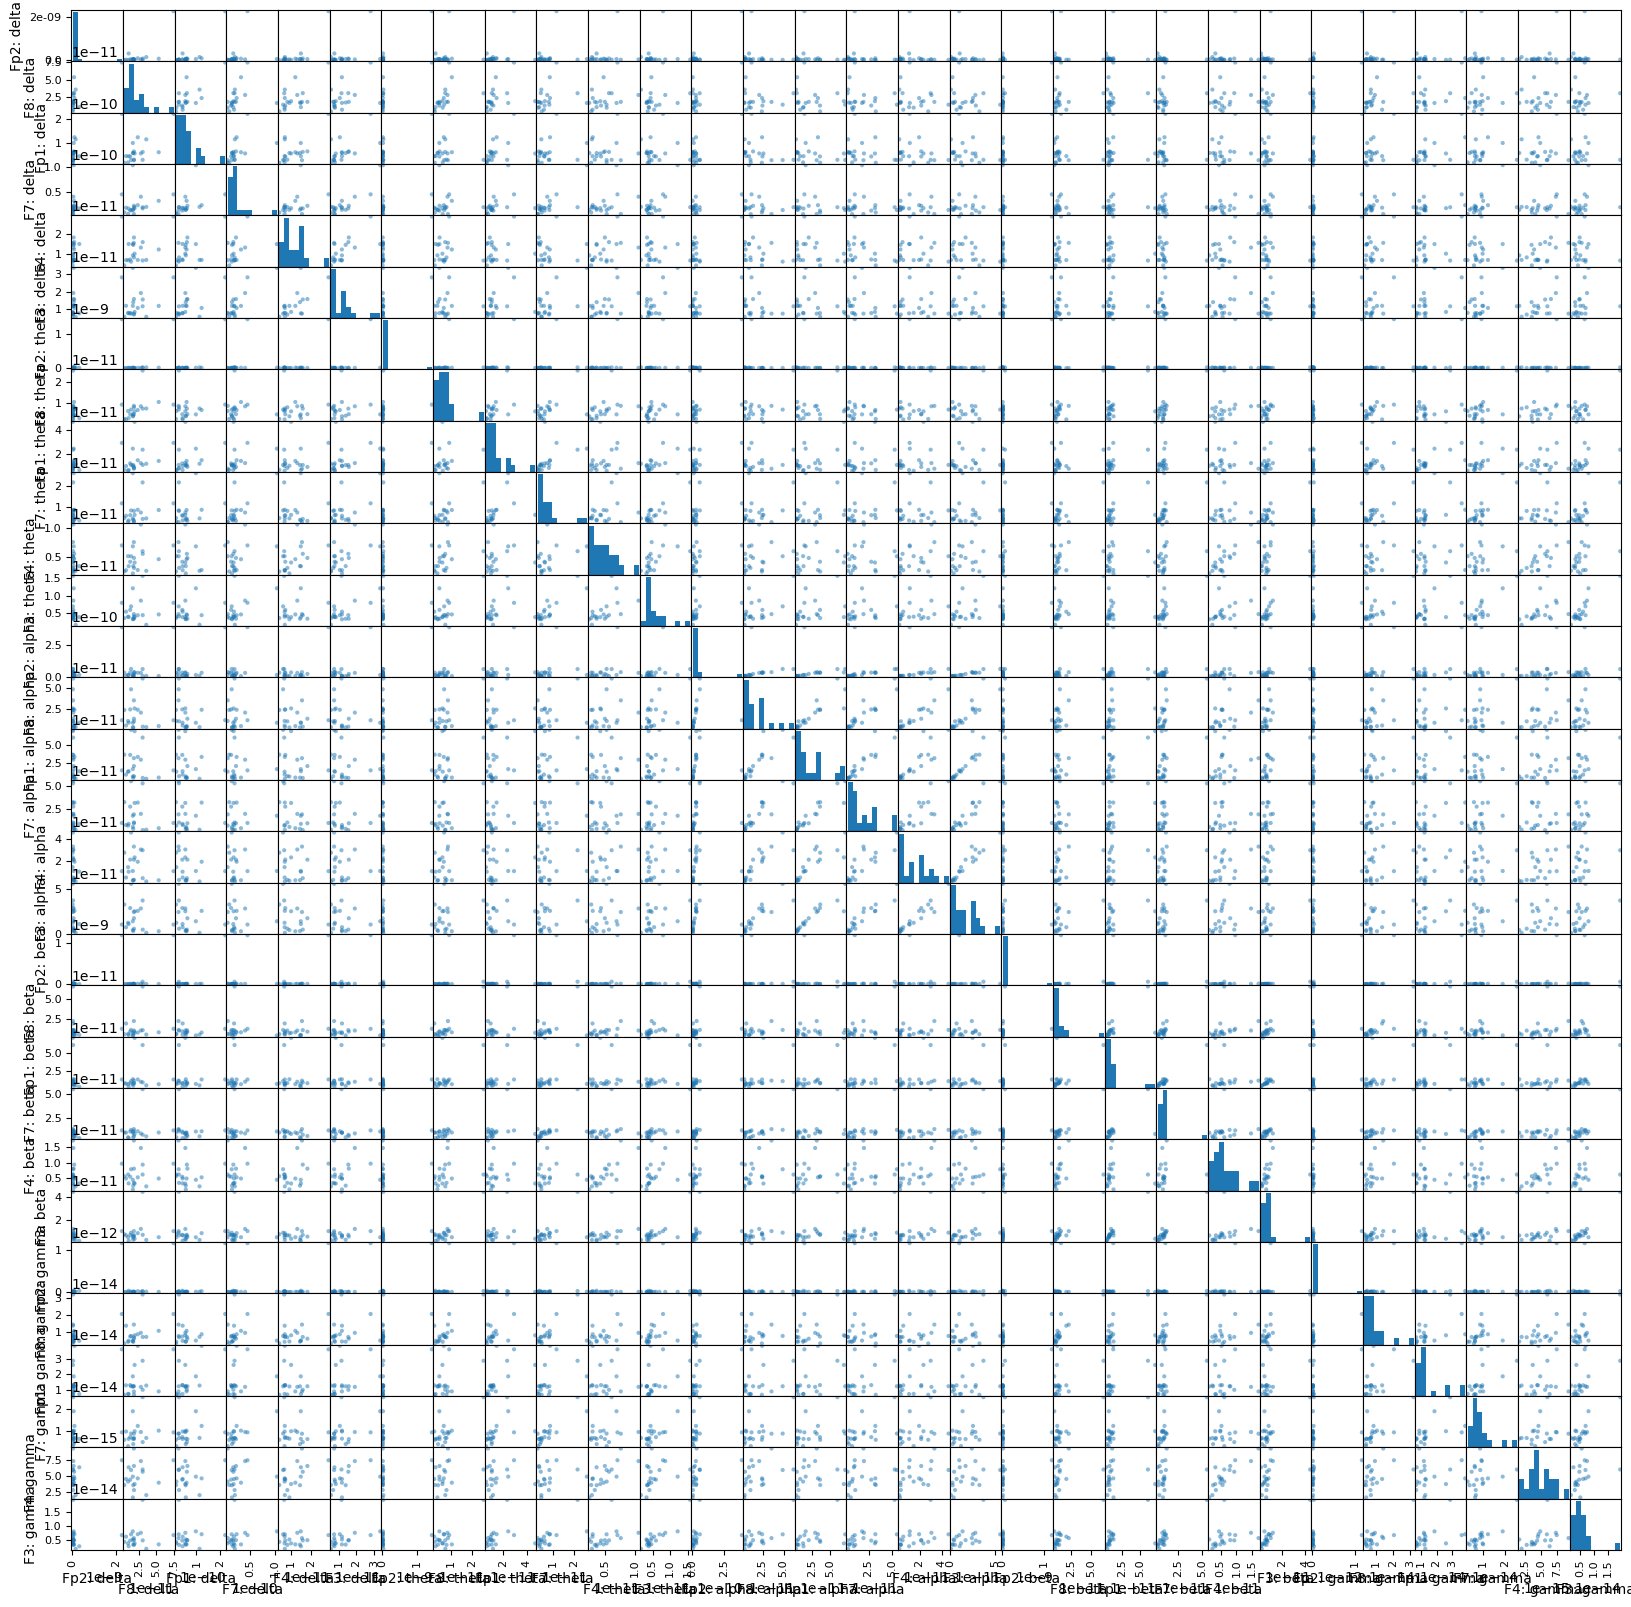

In [9]:
scatter_matrix(df, figsize=(20, 20))
pyplot.show()

In [ ]:
df.corr()

/var/folders/k8/k3w6nc9s10g2c1_y813nmnnw0000gr/T/ipykernel_47517/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Fp2: delta,F8: delta,Fp1: delta,F7: delta,F4: delta,F3: delta,Fp2: theta,F8: theta,Fp1: theta,F7: theta,F4: theta,F3: theta,Fp2: alpha,F8: alpha,Fp1: alpha,F7: alpha,F4: alpha,F3: alpha,Fp2: beta,F8: beta,Fp1: beta,F7: beta,F4: beta,F3: beta,Fp2: gamma,F8: gamma,Fp1: gamma,F7: gamma,F4: gamma,F3: gamma
Fp2: delta,1.000000,0.737723,0.806387,0.241219,0.727052,0.490669,0.991559,0.085024,0.330581,0.138442,0.224976,0.137475,0.961695,-0.128443,-0.145551,-0.160389,-0.137674,-0.160965,0.988723,-0.020094,-0.049166,-0.015128,0.163019,0.017552,0.993366,0.366556,0.504712,-0.000427,0.316579,0.030751
F8: delta,0.737723,1.000000,0.748132,0.289022,0.612923,0.438350,0.741864,0.438944,0.380597,0.237840,0.334615,0.196266,0.701184,-0.106000,-0.187342,-0.192913,-0.227629,-0.256128,0.741278,0.125003,0.071285,0.152420,0.191613,0.170653,0.736206,0.489355,0.473902,0.185328,0.205595,0.124499
Fp1: delta,0.806387,0.748132,1.000000,0.483991,0.631839,0.612744,0.790940,0.008553,0.413194,0.256875,0.126942,0.079395,0.730380,-0.290675,-0.246048,-0.240677,-0.299581,-0.293295,0.780430,-0.178823,-0.085501,-0.122638,0.002014,-0.116864,0.790326,0.206837,0.677803,0.117492,0.105711,-0.017897
F7: delta,0.241219,0.289022,0.483991,1.000000,0.387624,0.868759,0.242794,0.013210,0.377134,0.762731,0.412642,0.536888,0.204690,-0.191030,-0.142390,-0.071427,-0.147454,-0.122721,0.237216,-0.117906,-0.081488,0.009518,0.000607,-0.030470,0.239599,0.031366,0.291506,0.507733,0.111917,0.206177
F4: delta,0.727052,0.612923,0.631839,0.387624,1.000000,0.674851,0.704440,-0.017674,0.243601,0.072399,0.476286,0.088761,0.643213,-0.293112,-0.306070,-0.410575,-0.185255,-0.328284,0.697769,-0.125634,-0.141039,-0.183762,0.379377,-0.132944,0.705779,0.169650,0.239499,-0.064972,0.553625,-0.070731
F3: delta,0.490669,0.438350,0.612744,0.868759,0.674851,1.000000,0.506380,0.036317,0.367255,0.619577,0.533156,0.525848,0.461144,-0.228013,-0.214513,-0.181749,-0.160953,-0.182851,0.504891,-0.045982,-0.088208,0.016772,0.185491,0.039765,0.503399,0.163342,0.385224,0.372303,0.303366,0.267167
Fp2: theta,0.991559,0.741864,0.790940,0.242794,0.704440,0.506380,1.000000,0.118647,0.358940,0.166106,0.255637,0.174082,0.978798,-0.085256,-0.104973,-0.119277,-0.097940,-0.121177,0.999212,0.016081,-0.011986,0.024517,0.196119,0.059028,0.999629,0.400211,0.522746,0.024600,0.311313,0.074243
F8: theta,0.085024,0.438944,0.008553,0.013210,-0.017674,0.036317,0.118647,1.000000,0.284757,0.520586,0.371223,0.675198,0.207474,0.622734,0.345822,0.436601,0.257652,0.272838,0.150473,0.867976,0.563308,0.892902,0.219631,0.896557,0.119352,0.846347,0.384657,0.699708,0.257683,0.791974
Fp1: theta,0.330581,0.380597,0.413194,0.377134,0.243601,0.367255,0.358940,0.284757,1.000000,0.467964,0.183504,0.364176,0.401322,0.214425,0.463574,0.291324,0.097590,0.133756,0.365472,0.173633,0.775489,0.258346,-0.111549,0.191062,0.356419,0.358460,0.680513,0.475526,0.022627,0.274118
F7: theta,0.138442,0.237840,0.256875,0.762731,0.072399,0.619577,0.166106,0.520586,0.467964,1.000000,0.325349,0.878221,0.215128,0.331392,0.235926,0.397284,0.102322,0.211974,0.183924,0.458102,0.325068,0.614305,-0.071239,0.541147,0.166923,0.482577,0.481034,0.889066,0.097907,0.703569


### ML Part ###

In [96]:
array = df.values
X = array[:,0:30]
y = array[:,30]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.50, random_state=1,stratify=y)


In [97]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis('lsqr')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(max_leaf_nodes=3)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(kernel='linear')))

In [98]:
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=2, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.400000 (0.000000)
LDA: 0.700000 (0.100000)
KNN: 0.400000 (0.000000)
CART: 0.400000 (0.000000)
NB: 0.500000 (0.100000)
SVM: 0.400000 (0.000000)


In [99]:
model = LinearDiscriminantAnalysis('lsqr')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)
print(predictions)
print(Y_validation)

['Healthy' 'Healthy' 'Schizophrenia' 'Healthy' 'Schizophrenia' 'Healthy'
 'Schizophrenia' 'Schizophrenia' 'Healthy' 'Healthy']
['Healthy' 'Healthy' 'Healthy' 'Healthy' 'Schizophrenia' 'Healthy'
 'Schizophrenia' 'Schizophrenia' 'Schizophrenia' 'Schizophrenia']


In [100]:
classification_report(Y_validation, predictions)

'               precision    recall  f1-score   support\n\n      Healthy       0.67      0.80      0.73         5\nSchizophrenia       0.75      0.60      0.67         5\n\n     accuracy                           0.70        10\n    macro avg       0.71      0.70      0.70        10\n weighted avg       0.71      0.70      0.70        10\n'

In [101]:
confusion_matrix(Y_validation, predictions)

array([[4, 1],
       [2, 3]])

Text(113.9222222222222, 0.5, 'predicted label')

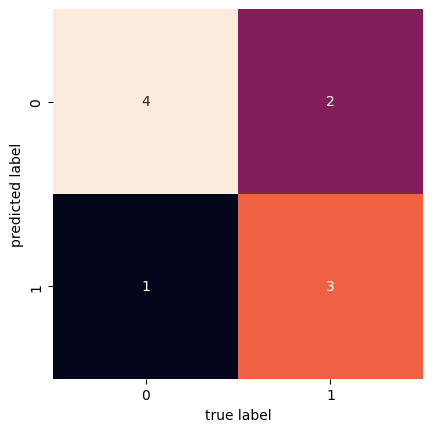

In [105]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(Y_validation, predictions) # answer and prediction put in
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')